# Workshop 1: Introduction to `PyPSA` & TYNDP reference grids

<img src="https://github.com/fneum/data-science-for-esm/raw/main/data-science-for-esm/pypsa-logo.png" width="300px" />

PyPSA stands for **Python for Power System Analysis**.

PyPSA is an open source Python package for simulating and optimising modern energy systems that include features such as

- conventional generators with unit commitment (ramp-up, ramp-down, start-up, shut-down),
- time-varying wind and solar generation,
- energy storage with efficiency losses and inflow/spillage for hydroelectricity
- coupling to other energy sectors (electricity, transport, heat, industry),
- conversion between energy carriers (e.g. electricity to hydrogen),
- transmission networks (AC, DC, other fuels)

PyPSA can be used for a variety of problem types (e.g. electricity market modelling, long-term investment planning, transmission network expansion planning), and is designed to scale well with large networks and long time series.

Compared to building power system by hand in `linopy`, PyPSA does the following things for you:

- manage data inputs
- build optimisation problem
- communicate with the solver
- retrieve and process optimisation results
- manage data outputs

### Dependencies

- `pandas` for storing data about network components and time series
- `numpy` and `scipy` for linear algebra and sparse matrix calculations
- `matplotlib` and `cartopy` for plotting on a map
- `networkx` for network calculations
- `linopy` for handling optimisation problems

:::{note}
Documentation for this package is available at https://pypsa.readthedocs.io.
:::

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa matplotlib cartopy highspy
```
:::

## Basic Structure

| Component | Description |
| --- | --- |
| [Network](https://pypsa.readthedocs.io/en/latest/components.html#network) | Container for all components. |
| [Bus](https://pypsa.readthedocs.io/en/latest/components.html#bus) | Node where components attach. |
| [Carrier](https://pypsa.readthedocs.io/en/latest/components.html#carrier) | Energy carrier or technology (e.g. electricity, hydrogen, gas, coal, oil, biomass, on-/offshore wind, solar). Can track properties such as specific carbon dioxide emissions or nice names and colors for plots. |
| [Load](https://pypsa.readthedocs.io/en/latest/components.html#load) | Energy consumer (e.g. electricity demand). |
| [Generator](https://pypsa.readthedocs.io/en/latest/components.html#generator) | Generator (e.g. power plant, wind turbine, PV panel). |
| [Line](https://pypsa.readthedocs.io/en/latest/components.html#line) | Power distribution and transmission lines (overhead and cables). |
| [Link](https://pypsa.readthedocs.io/en/latest/components.html#link) | Links connect two buses with controllable energy flow, direction-control and losses. They can be used to model: <ul><li>HVDC links</li><li>HVAC lines (neglecting KVL, only net transfer capacities (NTCs))</li><li>conversion between carriers (e.g. electricity to hydrogen in electrolysis)</li></ul> |
| [StorageUnit](https://pypsa.readthedocs.io/en/latest/components.html#storage-unit) | Storage with fixed nominal energy-to-power ratio. |
| [GlobalConstraint](https://pypsa.readthedocs.io/en/latest/components.html#global-constraints) | Constraints affecting many components at once, such as emission limits. |
| [Store](https://pypsa.readthedocs.io/en/latest/components.html#store) | Storage with separately extendable energy capacity. |
|  | **not used in this course** |
| [LineType](https://pypsa.readthedocs.io/en/latest/components.html#line-types) | Standard line types. |
| [Transformer](https://pypsa.readthedocs.io/en/latest/components.html#transformer) | 2-winding transformer. |
| [TransformerType](https://pypsa.readthedocs.io/en/latest/components.html#transformer-types) | Standard types of 2-winding transformer. |
| [ShuntImpedance](https://pypsa.readthedocs.io/en/latest/components.html#shunt-impedance) | Shunt. |


:::{note}
Links in the table lead to documentation for each component.
:::

<img src="https://pypsa.readthedocs.io/en/latest/_images/buses.png" width="500px" />


:::{warning}
Per unit values of voltage and impedance are used internally for network calculations. It is assumed internally that the base power is **1 MW**.
:::

## From structured data to optimisation

The design principle of PyPSA is that basically each component is associated with a set of variables and constraints that will be added to the optimisation model based on the input data stored for the components.

For an *hourly* electricity market simulation, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{i,s,t}; f_{\ell,t}; g_{i,r,t,\text{charge}}; g_{i,r,t,\text{discharge}}; e_{i,r,t}} \sum_s o_{s} g_{i,s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{i,s,t} \leq \hat{g}_{i,s,t} G_{i,s}  & \text{generation limits : generator} \\
-F_\ell &\leq f_{\ell,t} \leq F_\ell & \text{transmission limits : line}  \\
d_{i,t} &= \sum_s g_{i,s,t} + \sum_r g_{i,r,t,\text{discharge}} - \sum_r g_{i,r,t,\text{charge}} - \sum_\ell K_{i\ell} f_{\ell,t} & \text{KCL : bus} \\
 0 &=\sum_\ell C_{\ell c} x_\ell f_{\ell,t} & \text{KVL : cycles} \\
0 & \leq g_{i,r,t,\text{discharge}} \leq G_{i,r,\text{discharge}}& \text{discharge limits : storage unit} \\
    0 & \leq g_{i,r,t,\text{charge}} \leq G_{i,r,\text{charge}} & \text{charge limits : storage unit} \\
    0 & \leq e_{i,r,t} \leq E_{i,r} & \text{energy limits : storage unit} \\
    e_{i,r,t} &= \eta^0_{i,r,t} e_{i,r,t-1} + \eta^1_{i,r,t}g_{i,r,t,\text{charge}} -  \frac{1}{\eta^2_{i,r,t}} g_{i,r,t,\text{discharge}} & \text{consistency : storage unit} \\
    e_{i,r,0} & = e_{i,r,|T|-1}  & \text{cyclicity : storage unit}
\end{align}

**Decision variables:**

- $g_{i,s,t}$ is the generator dispatch at bus $i$, technology $s$, time step $t$,
- $f_{\ell,t}$ is the power flow in line $\ell$,
- $g_{i,r,t,\text{dis-/charge}}$ denotes the charge and discharge of storage unit $r$ at bus $i$ and time step $t$,
- $e_{i,r,t}$ is the state of charge of storage $r$ at bus $i$ and time step $t$.

**Parameters:**

- $o_{i,s}$ is the marginal generation cost of technology $s$ at bus $i$,
- $x_\ell$ is the reactance of transmission line $\ell$,
- $K_{i\ell}$ is the incidence matrix,
- $C_{\ell c}$ is the cycle matrix,
- $G_{i,s}$ is the nominal capacity of the generator of technology $s$ at bus $i$,
- $F_{\ell}$ is the rating of the transmission line $\ell$,
- $E_{i,r}$ is the energy capacity of storage $r$ at bus $i$,
- $\eta^{0/1/2}_{i,r,t}$ denote the standing (0), charging (1), and discharging (2) efficiencies.

:::{note}
For a full reference to the optimisation problem description, see https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html
:::

# Using the PyPSA framework: a simple example

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket 🚀 in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews
%env HV_DOC_HTML=true
```
:::

In [81]:
# For executing this notebook in Google Colab
#!pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews
# %env HV_DOC_HTML=true

# Depedencies

In [ ]:
# By convention, PyPSA is imported without an alias:
import pypsa
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import holoviews as hv
import cartopy.crs as ccrs
from pypsa.plot.maps.static import add_legend_circles, add_legend_patches, add_legend_lines
from pathlib import Path

plt.style.use("bmh")

### Simple electricity market problem
Copyright (c) 2025, Iegor Riepin

generator 1: "gas" -- marginal cost 70 EUR/MWh -- capacity 50 MW

generator 2: "nuclear" -- marginal cost 10 EUR/MWh -- capacity 100 MW

load: "Consumer" -- demand 120 MW

single time step ("now")

single node ("Springfield")

### Building a basic network

In [83]:
# First, we create a network object which serves as the container for all components
n = pypsa.Network()

In [84]:
n

Empty Unnamed PyPSA Network
---------------------
Components: none
Snapshots: 1

The second component we need are buses. **Buses** are the fundamental nodes of the network, to which all other components like loads, generators and transmission lines attach. They enforce energy conservation for all elements feeding in and out of it (i.e. Kirchhoff’s Current Law).

Components can be added to the network `n` using the `n.add()` function. It takes the component name as a first argument, the name of the component as a second argument and possibly further parameters as keyword arguments. Let's use this function, to add buses for each country to our network:

In [85]:
n.add("Bus", "Springfield", v_nom=380, carrier="AC")

Index(['Springfield'], dtype='object')

For each class of components, the data describing the components is stored in a `pandas.DataFrame`. For example, all static data for buses is stored in `n.buses`

In [86]:
n.buses

v_nom type    x    y carrier unit location  v_mag_pu_set  \
Bus                                                                     
Springfield  380.0       0.0  0.0      AC                         1.0   

             v_mag_pu_min  v_mag_pu_max control generator sub_network  
Bus                                                                    
Springfield           0.0           inf      PQ

You see there are many more attributes than we specified while adding the buses; many of them are filled with default parameters which were added. You can look up the field description, defaults and status (required input, optional input, output) for buses here https://pypsa.readthedocs.io/en/latest/components.html#bus, and analogous for all other components.

The `n.add()` function lets you add any component to the network object `n`:

In [87]:
n.add(
    "Generator",
    "gas",
    bus="Springfield",
    p_nom_extendable=False,
    marginal_cost=70,  # €/MWh
    p_nom=50,  # MW
)
n.add(
    "Generator",
    "nuclear",
    bus="Springfield",
    p_nom_extendable=False,
    marginal_cost=10,  # €/MWh
    p_nom=100,  # MW
)

Index(['nuclear'], dtype='object')

The method `n.add()` also allows you to add multiple components at once. For instance, multiple **carriers** for the fuels with information on specific carbon dioxide emissions, a nice name, and colors for plotting. For this, the function takes the component name as the first argument and then a list of component names and then optional arguments for the parameters. Here, scalar values, lists, dictionary or `pandas.Series` are allowed. The latter two needs keys or indices with the component names.

As a result, the `n.generators` DataFrame looks like this:

In [88]:
n.generators

bus control type  p_nom  p_nom_mod  p_nom_extendable  \
Generator                                                                 
gas        Springfield      PQ        50.0        0.0             False   
nuclear    Springfield      PQ       100.0        0.0             False   

           p_nom_min  p_nom_max  p_min_pu  p_max_pu  ...  min_up_time  \
Generator                                            ...                
gas              0.0        inf       0.0       1.0  ...            0   
nuclear          0.0        inf       0.0       1.0  ...            0   

           min_down_time  up_time_before  down_time_before  ramp_limit_up  \
Generator                                                                   
gas                    0               1                 0            NaN   
nuclear                0               1                 0            NaN   

          ramp_limit_down  ramp_limit_start_up  ramp_limit_shut_down  weight  \
Generator                                                                      
gas                   NaN                  1.0                   1.0     1.0   
nuclear               NaN                  1.0                   1.0     1.0   

           p_nom_opt  
Generator             
gas              0.0  
nuclear          0.0  

[2 rows x 37 columns]

Next, we're going to add the electricity demand.

A positive value for `p_set` means consumption of power from the bus.

In [89]:
n.add(
    "Load",
    "Small town",
    bus="Springfield",
    p_set=120,  # MW
)

Index(['Small town'], dtype='object')

In [90]:
n.loads

bus carrier type  p_set  q_set  sign  active
Load                                                            
Small town  Springfield               120.0    0.0  -1.0    True

## Optimisation

The design principle of PyPSA is that basically each component is associated with a set of variables and constraints that will be added to the optimisation model based on the input data stored for the components. 

For this dispatch problem, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{s,t};} \sum_{t,s} o_{s} g_{s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{s,t} \leq G_{s}  & \text{generation limits : generator} \\
D_t &= \sum_s g_{s,t} & \text{market clearing : bus} \\
\end{align}

**Decision variables:**

- $g_{s,t}$ is the generator dispatch of technology $s$ at time $t$

**Parameters:**

- $o_{s}$ is the marginal generation cost of technology $s$
- $G_{s}$ is the nominal capacity of technology $s$
- $D_t$ is the power demand in Springfiled at time $t$


With all input data transferred into the PyPSA's data structure (`network`), we can now build and run the resulting optimisation problem. In PyPSA, building, solving and retrieving results from the optimisation model is contained in a single function call `n.optimize()`. This function optimizes dispatch and investment decisions for least cost adhering to the constraints defined in the network.

The `n.optimize()` function can take a variety of arguments. The most relevant for the moment is the choice of the solver (e.g. "highs" and "gurobi"). They need to be installed on your computer, to use them here!

In [91]:
n.optimize(solver_name="highs")

Index(['Springfield'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2 primals, 5 duals
Objective: 2.40e+03
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-4u7u9rnb has 5 rows; 2 cols; 6 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+01, 7e+01]
  Bound  [0e+00, 0e+00]
  RHS    [5e+01, 1e+02]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-5); columns 0(-2); elements 0(-6) - Reduced to empty
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-4u7u9rnb
Model status        : Optimal
Objective value     :  2.4000000000e+03
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/mc/ydz19ftd49sd7q8qgcq53tkh0000gn/T/linopy-solve-hun6cm1y.sol


('ok', 'optimal')

Let's have a look at the results. The network object `n` contains now the objective value and the results for the decision variables.

In [92]:
n.objective

2400.0

Since the power flow and dispatch are generally time-varying quantities, these are stored in a different locations than e.g. `n.generators`. They are stored in `n.generators_t`. Thus, to find out the dispatch of the generators, run

In [93]:
n.generators_t.p

Generator   gas  nuclear
snapshot                
now        20.0    100.0

In [94]:
n.buses_t.marginal_price

Bus       Springfield
snapshot             
now              70.0

In [95]:
n.generators_t.mu_upper

Empty DataFrame
Columns: []
Index: [now]

### Explore pypsa model

In [96]:
n.model

Linopy LP model

Variables:
----------
 * Generator-p (snapshot, Generator)

Constraints:
------------
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Bus-nodal_balance (Bus, snapshot)

Status:
-------
ok

In [97]:
n.model.constraints

linopy.model.Constraints
------------------------
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Bus-nodal_balance (Bus, snapshot)

In [98]:
n.model.constraints["Generator-fix-p-upper"]

Constraint `Generator-fix-p-upper` [snapshot: 1, Generator-fix: 2]:
-------------------------------------------------------------------
[now, gas]: +1 Generator-p[now, gas]         ≤ 50.0
[now, nuclear]: +1 Generator-p[now, nuclear] ≤ 100.0

In [99]:
n.model.constraints["Bus-nodal_balance"]

Constraint `Bus-nodal_balance` [Bus: 1, snapshot: 1]:
-----------------------------------------------------
[Springfield, now]: +1 Generator-p[now, gas] + 1 Generator-p[now, nuclear] = 120.0

In [100]:
n.model.objective

Objective:
----------
LinearExpression: +70 Generator-p[now, gas] + 10 Generator-p[now, nuclear]
Sense: min
Value: 2400.0

# Hands-on Session 1: Building the reference grids

## Load Example Data

In [131]:
from urllib.request import urlretrieve

urls = {
    "pre-network.nc": "https://drive.google.com/uc?export=download&id=1KizODRyW0UVLKzIY5MZlDZi52zN0tSZc",
    "post-network.nc": "https://drive.google.com/uc?export=download&id=1O9bkv7382rAhnY493aa9SLaXl4AdVfSw",
    "bidding_zones.geojson": "https://drive.google.com/uc?export=download&id=1ZjcNdSiE9OTUetcV1MBV8qn6KIKMYQkM",
}
for name, url in urls.items():
    print(name)
    urlretrieve(url, name)

pre-network.nc
post-network.nc
bidding_zones.geojson


First, let's load a pre-composed PyPSA Network:

In [132]:
n = pypsa.Network("pre-network.nc")

INFO:pypsa.io:Imported network pre-network.nc has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores


And let's get a general overview of the components in it:

In [133]:
n.component

<bound method Network.component of PyPSA Network 'PyPSA-Eur (tyndp-raw)'
-------------------------------------
Components:
 - Bus: 670
 - Carrier: 76
 - Generator: 656
 - GlobalConstraint: 2
 - Link: 2059
 - Load: 197
 - Shape: 62
 - StorageUnit: 69
 - Store: 349
Snapshots: 365>

We have buses which represent the different nodes in the model where components attach.

In [134]:
n.buses

v_nom type          x          y  \
Bus                                                                  
AL00                              380.0       20.036884  41.117588   
AT00                              380.0       14.822183  47.668898   
BA00                              380.0       17.867837  43.982016   
BE00                              380.0        4.967931  50.470635   
BG00                              380.0       25.323948  42.668760   
...                                 ...  ...        ...        ...   
SI00 urban decentral water tanks    1.0       14.565063  46.195746   
SK00 rural heat                     1.0       18.778426  48.645144   
SK00 rural water tanks              1.0       18.778426  48.645144   
SK00 urban decentral heat           1.0       18.778426  48.645144   
SK00 urban decentral water tanks    1.0       18.778426  48.645144   

                                                      carrier    unit  \
Bus                                                                     
AL00                                                       AC  MWh_el   
AT00                                                       AC  MWh_el   
BA00                                                       AC  MWh_el   
BE00                                                       AC  MWh_el   
BG00                                                       AC  MWh_el   
...                                                       ...     ...   
SI00 urban decentral water tanks  urban decentral water tanks  MWh_th   
SK00 rural heat                                    rural heat  MWh_th   
SK00 rural water tanks                      rural water tanks  MWh_th   
SK00 urban decentral heat                urban decentral heat  MWh_th   
SK00 urban decentral water tanks  urban decentral water tanks  MWh_th   

                                 location  v_mag_pu_set  v_mag_pu_min  \
Bus                                                                     
AL00                                 AL00           1.0           0.0   
AT00                                 AT00           1.0           0.0   
BA00                                 BA00           1.0           0.0   
BE00                                 BE00           1.0           0.0   
BG00                                 BG00           1.0           0.0   
...                                   ...           ...           ...   
SI00 urban decentral water tanks     SI00           1.0           0.0   
SK00 rural heat                      SK00           1.0           0.0   
SK00 rural water tanks               SK00           1.0           0.0   
SK00 urban decentral heat            SK00           1.0           0.0   
SK00 urban decentral water tanks     SK00           1.0           0.0   

                                  v_mag_pu_max control generator sub_network  \
Bus                                                                            
AL00                                       inf      PQ                         
AT00                                       inf      PQ                         
BA00                                       inf      PQ                         
BE00                                       inf      PQ                         
BG00                                       inf      PQ                         
...                                        ...     ...       ...         ...   
SI00 urban decentral water tanks           inf      PQ                         
SK00 rural heat                            inf      PQ                         
SK00 rural water tanks                     inf      PQ                         
SK00 urban decentral heat                  inf      PQ                         
SK00 urban decentral water tanks           inf      PQ                         

                                 country  substation_lv  substation_off  
Bus                                                                      
AL00                              

And let's zoom on a specific country.

In [135]:
n.buses.query("country=='IT' and carrier=='AC'")

v_nom type          x          y carrier    unit  location  \
Bus                                                                         
ITCA           380.0       16.634892  38.985885      AC  MWh_el      ITCA   
ITCN           380.0       11.238605  43.418039      AC  MWh_el      ITCN   
ITCS           380.0       13.162117  41.846461      AC  MWh_el      ITCS   
ITN1           380.0        9.703872  45.440276      AC  MWh_el      ITN1   
ITS1           380.0       16.501565  40.927422      AC  MWh_el      ITS1   
ITSA           380.0        9.097371  40.067626      AC  MWh_el      ITSA   
ITSI           380.0       13.863833  37.546811      AC  MWh_el      ITSI   
ITVI           380.0       13.863833  37.546811      AC  MWh_el      ITVI   
IT H2 Z2 DRES  380.0       16.634892  38.985885      AC  MWh_el  IT H2 Z2   

               v_mag_pu_set  v_mag_pu_min  v_mag_pu_max control generator  \
Bus                                                                         
ITCA                    1.0           0.0           inf      PQ             
ITCN                    1.0           0.0           inf      PQ             
ITCS                    1.0           0.0           inf      PQ             
ITN1                    1.0           0.0           inf      PQ             
ITS1                    1.0           0.0           inf      PQ             
ITSA                    1.0           0.0           inf      PQ             
ITSI                    1.0           0.0           inf      PQ             
ITVI                    1.0           0.0           inf      PQ             
IT H2 Z2 DRES           1.0           0.0           inf      PQ             

              sub_network country  substation_lv  substation_off  
Bus                                                               
ITCA                           IT            1.0             1.0  
ITCN                           IT            1.0             1.0  
ITCS                           IT            1.0             1.0  
ITN1                           IT            1.0             1.0  
ITS1                           IT            1.0             1.0  
ITSA                           IT            1.0             1.0  
ITSI                           IT            1.0             1.0  
ITVI                           IT            0.0             0.0  
IT H2 Z2 DRES                  IT            1.0             1.0

We can also explore the network spatially.

In [136]:
n.explore()

/var/folders/mc/ydz19ftd49sd7q8qgcq53tkh0000gn/T/ipykernel_70260/2783070282.py:1: DeprecatedWarning:

explore is deprecated. Use `n.plot.explore()` as a drop-in replacement instead.

INFO:pypsa.plot.maps.interactive:Components rendered on the map: Bus, Link.
INFO:pypsa.plot.maps.interactive:Components omitted as they are missing or not selected: Generator, Line, Load, StorageUnit, Transformer.


Generators which represent generating units (e.g. power plant, wind turbine, PV panel):

In [137]:
n.generators

bus  \
Generator                                                                 
AL00 solar                                                         AL00   
AT00 solar                                                         AT00   
BA00 solar                                                         BA00   
BE00 solar                                                         BE00   
BG00 solar                                                         BG00   
...                                                                 ...   
SI00 urban decentral solar thermal collector  SI00 urban decentral heat   
SK00 rural heat vent                                    SK00 rural heat   
SK00 rural solar thermal collector                      SK00 rural heat   
SK00 urban decentral heat vent                SK00 urban decentral heat   
SK00 urban decentral solar thermal collector  SK00 urban decentral heat   

                                             control type     p_nom  \
Generator                                                             
AL00 solar                                        PQ         21.000   
AT00 solar                                        PQ       2042.934   
BA00 solar                                        PQ         34.890   
BE00 solar                                        PQ       5572.800   
BG00 solar                                        PQ       1100.211   
...                                              ...  ...       ...   
SI00 urban decentral solar thermal collector      PQ          0.000   
SK00 rural heat vent                              PQ          0.000   
SK00 rural solar thermal collector                PQ          0.000   
SK00 urban decentral heat vent                    PQ          0.000   
SK00 urban decentral solar thermal collector      PQ          0.000   

                                              p_nom_mod  p_nom_extendable  \
Generator                                                                   
AL00 solar                                          0.0              True   
AT00 solar                                          0.0              True   
BA00 solar                                          0.0              True   
BE00 solar                                          0.0              True   
BG00 solar                                          0.0              True   
...                                                 ...               ...   
SI00 urban decentral solar thermal collector        0.0              True   
SK00 rural heat vent                                0.0              True   
SK00 rural solar thermal collector                  0.0              True   
SK00 urban decentral heat vent                      0.0              True   
SK00 urban decentral solar thermal collector        0.0              True   

                                              p_nom_min     p_nom_max  \
Generator                                                               
AL00 solar                                       21.000  5.429033e+04   
AT00 solar                                     2042.934  1.760448e+05   
BA00 solar                                       34.890  8.721107e+04   
BE00 solar                                     5572.800  1.064523e+05   
BG00 solar                                     1100.211  2.326542e+05   
...                                                 ...           ...   
SI00 urban decentral solar thermal collector      0.000           inf   
SK00 rural heat vent                              0.000           inf   
SK00 rural solar thermal collector                0.000           inf   
SK00 urban decentral heat vent                    0.000           inf   
SK00 urban decentral solar thermal collector      0.000           inf   

                                              p_min_pu  p_max_pu  ...  \
Generator                                                         ...   
AL00 solar                                         0.0       1.0  ... 

Links connect two buses with controllable energy flow, direction-control and losses. They can be used to model: <ul><li>HVDC links</li><li>HVAC lines (neglecting KVL, only net transfer capacities (NTCs))</li><li>conversion between carriers (e.g. electricity to hydrogen in electrolysis)</li></ul>

In [138]:
n.links

bus0  \
Link                                                                            
AL00-GR00-DC                                                             AL00   
AL00-ME00-DC                                                             AL00   
AL00-MK00-DC                                                             AL00   
AL00-RS00-DC                                                             AL00   
AT00-CH00-DC                                                             AT00   
...                                                                       ...   
SK00 urban decentral air heat pump                           SK00 low voltage   
SK00 urban decentral gas boiler                                        EU gas   
SK00 urban decentral resistive heater                        SK00 low voltage   
SK00 urban decentral water tanks charger            SK00 urban decentral heat   
SK00 urban decentral water tanks discharger  SK00 urban decentral water tanks   

                                                                         bus1  \
Link                                                                            
AL00-GR00-DC                                                             GR00   
AL00-ME00-DC                                                             ME00   
AL00-MK00-DC                                                             MK00   
AL00-RS00-DC                                                             RS00   
AT00-CH00-DC                                                             CH00   
...                                                                       ...   
SK00 urban decentral air heat pump                  SK00 urban decentral heat   
SK00 urban decentral gas boiler                     SK00 urban decentral heat   
SK00 urban decentral resistive heater               SK00 urban decentral heat   
SK00 urban decentral water tanks charger     SK00 urban decentral water tanks   
SK00 urban decentral water tanks discharger         SK00 urban decentral heat   

                                            type  \
Link                                               
AL00-GR00-DC                                       
AL00-ME00-DC                                       
AL00-MK00-DC                                       
AL00-RS00-DC                                       
AT00-CH00-DC                                       
...                                          ...   
SK00 urban decentral air heat pump                 
SK00 urban decentral gas boiler                    
SK00 urban decentral resistive heater              
SK00 urban decentral water tanks charger           
SK00 urban decentral water tanks discharger        

                                                                            carrier  \
Link                                                                                  
AL00-GR00-DC                                                                     DC   
AL00-ME00-DC                                                                     DC   
AL00-MK00-DC                                                                     DC   
AL00-RS00-DC                                                                     DC   
AT00-CH00-DC                                                                     DC   
...                                                                             ...   
SK00 urban decentral air heat pump                    urban decentral air heat pump   
SK00 urban decentral gas boiler                          urban decentral gas boiler   
SK00 urban decentral resistive heater              urban decentral resistive heater   
SK00 urban decentral water tanks charger        urban decentral water tanks charger   
SK00 urban decentral water tanks discharger  urban decentral water tanks discharger   

                                             efficiency  active  build_year  \
Link                                                                         

In [139]:
n.links.query("carrier.str.contains('H2') and Link.str.contains('DE')").sort_values(
    by=["carrier", "bus0", "bus1"]
)

bus0        bus1 type          carrier  \
Link                                                                            
DE H2 Z2 DRES Electrolysis    DE H2 Z2 DRES    DE H2 Z2       H2 Electrolysis   
DE00 H2 Z1 Electrolysis                DE00    DE H2 Z1       H2 Electrolysis   
DE00 H2 Z2 Electrolysis                DE00    DE H2 Z2       H2 Electrolysis   
H2 pipeline AT -> DE               AT H2 Z2    DE H2 Z2           H2 pipeline   
H2 pipeline BE -> DE               BE H2 Z2    DE H2 Z2           H2 pipeline   
H2 pipeline CZ -> DE               CZ H2 Z2    DE H2 Z2           H2 pipeline   
H2 pipeline DEH2Z1 -> DEH2Z2       DE H2 Z1    DE H2 Z2           H2 pipeline   
H2 pipeline DE -> AT               DE H2 Z2    AT H2 Z2           H2 pipeline   
H2 pipeline DE -> BE               DE H2 Z2    BE H2 Z2           H2 pipeline   
H2 pipeline DE -> CZ               DE H2 Z2    CZ H2 Z2           H2 pipeline   
H2 pipeline DEH2Z2 -> DEH2Z1       DE H2 Z2    DE H2 Z1           H2 pipeline   
H2 pipeline DE -> DK               DE H2 Z2    DK H2 Z2           H2 pipeline   
H2 pipeline DE -> FR               DE H2 Z2    FR H2 Z2           H2 pipeline   
H2 pipeline DE -> IBFI             DE H2 Z2  IBFI H2 Z2           H2 pipeline   
H2 pipeline DE -> NL               DE H2 Z2    NL H2 Z2           H2 pipeline   
H2 pipeline DE -> PL               DE H2 Z2    PL H2 Z2           H2 pipeline   
H2 pipeline DK -> DE               DK H2 Z2    DE H2 Z2           H2 pipeline   
H2 pipeline FR -> DE               FR H2 Z2    DE H2 Z2           H2 pipeline   
H2 pipeline IBFI -> DE           IBFI H2 Z2    DE H2 Z2           H2 pipeline   
H2 pipeline NL -> DE               NL H2 Z2    DE H2 Z2           H2 pipeline   
H2 pipeline PL -> DE               PL H2 Z2    DE H2 Z2           H2 pipeline   
DE00 H2 Z2 turbine                 DE H2 Z2        DE00            H2 turbine   

                              efficiency  active  build_year  lifetime  \
Link                                                                     
DE H2 Z2 DRES Electrolysis        0.6217    True           0      25.0   
DE00 H2 Z1 Electrolysis           0.6217    True           0      25.0   
DE00 H2 Z2 Electrolysis           0.6217    True           0      25.0   
H2 pipeline AT -> DE              1.0000    True           0      50.0   
H2 pipeline BE -> DE              1.0000    True           0      50.0   
H2 pipeline CZ -> DE              1.0000    True           0      50.0   
H2 pipeline DEH2Z1 -> DEH2Z2      1.0000    True           0      50.0   
H2 pipeline DE -> AT              1.0000    True           0      50.0   
H2 pipeline DE -> BE              1.0000    True           0      50.0   
H2 pipeline DE -> CZ              1.0000    True           0      50.0   
H2 pipeline DEH2Z2 -> DEH2Z1      1.0000    True           0      50.0   
H2 pipeline DE -> DK              1.0000    True           0      50.0   
H2 pipeline DE -> FR              1.0000    True           0      50.0   
H2 pipeline DE -> IBFI            1.0000    True           0      50.0   
H2 pipeline DE -> NL              1.0000    True           0      50.0   
H2 pipeline DE -> PL              1.0000    True           0      50.0   
H2 pipeline DK -> DE              1.0000    True           0      50.0   
H2 pipeline FR -> DE              1.0000    True           0      50.0   
H2 pipeline IBFI -> DE            1.0000    True           0      50.0   
H2 pipeline NL -> DE              1.0000    True           0      50.0   
H2 pipeline PL -> DE              1.0000    True           0      50.0   
DE00 H2 Z2 turbine                0.5800    True           0      25.0   

                                p_nom  p_nom_mod  ...  bidirectional  \
Link                                              ...                  
DE H2 Z2 DRES Electrolysis        0.0        0.0  ...            NaN   
DE00 H2 Z1 Electrolysis           0.0        0.0  ...            NaN   
DE00 H2 Z2 Electrolysis      

In [140]:
n.links.query("carrier == 'DC'")

bus0  bus1 type carrier  efficiency  active  build_year  \
Link                                                                    
AL00-GR00-DC  AL00  GR00           DC         1.0    True           0   
AL00-ME00-DC  AL00  ME00           DC         1.0    True           0   
AL00-MK00-DC  AL00  MK00           DC         1.0    True           0   
AL00-RS00-DC  AL00  RS00           DC         1.0    True           0   
AT00-CH00-DC  AT00  CH00           DC         1.0    True           0   
...            ...   ...  ...     ...         ...     ...         ...   
SI00-ITN1-DC  SI00  ITN1           DC         1.0    True           0   
SK00-AT00-DC  SK00  AT00           DC         1.0    True           0   
SK00-CZ00-DC  SK00  CZ00           DC         1.0    True           0   
SK00-HU00-DC  SK00  HU00           DC         1.0    True           0   
SK00-PL00-DC  SK00  PL00           DC         1.0    True           0   

              lifetime   p_nom  p_nom_mod  ...  bidirectional  reversed  \
Link                                       ...                            
AL00-GR00-DC       inf   600.0        0.0  ...            NaN     False   
AL00-ME00-DC       inf   400.0        0.0  ...            NaN     False   
AL00-MK00-DC       inf   500.0        0.0  ...            NaN     False   
AL00-RS00-DC       inf   250.0        0.0  ...            NaN     False   
AT00-CH00-DC       inf  1200.0        0.0  ...            NaN     False   
...                ...     ...        ...  ...            ...       ...   
SI00-ITN1-DC       inf  1153.0        0.0  ...            NaN     False   
SK00-AT00-DC       inf     0.0        0.0  ...            NaN     False   
SK00-CZ00-DC       inf  1100.0        0.0  ...            NaN     False   
SK00-HU00-DC       inf  2513.0        0.0  ...            NaN     False   
SK00-PL00-DC       inf   818.0        0.0  ...            NaN     False   

              location  voltage  underground  length_original          tags  \
Link                                                                          
AL00-GR00-DC              380.0          1.0       219.635111  AL00 -> GR00   
AL00-ME00-DC              380.0          1.0       189.342890  AL00 -> ME00   
AL00-MK00-DC              380.0          1.0       153.308707  AL00 -> MK00   
AL00-RS00-DC              380.0          1.0       351.420535  AL00 -> RS00   
AT00-CH00-DC              380.0          1.0       502.028400  AT00 -> CH00   
...                ...      ...          ...              ...           ...   
SI00-ITN1-DC              380.0          1.0       387.474841  SI00 -> ITN1   
SK00-AT00-DC              380.0          1.0       313.877829  SK00 -> AT00   
SK00-CZ00-DC              380.0          1.0       257.961191  SK00 -> CZ00   
SK00-HU00-DC              380.0          1.0       160.649817  SK00 -> HU00   
SK00-PL00-DC              380.0          1.0       380.625235  SK00 -> PL00   

              energy to power ratio  \
Link                                  
AL00-GR00-DC                    NaN   
AL00-ME00-DC                    NaN   
AL00-MK00-DC                    NaN   
AL00-RS00-DC                    NaN   
AT00-CH00-DC                    NaN   
...                             ...   
SI00-ITN1-DC                    NaN   
SK00-AT00-DC                    NaN   
SK00-CZ00-DC                    NaN   
SK00-HU00-DC                    NaN   
SK00-PL00-DC                    NaN   

                                                       geometry  \
Link                                                              
AL00-GR00-DC  LINESTRING (20.036883988642362 41.117587702511...   
AL00-ME00-DC  LINESTRING (20.036883988642362 41.117587702511...   
AL00-MK00-DC  LINESTRING (20.036883988642362 41.117587702511...   
AL00-RS00-DC  LINESTRING (20.036883988642362 41.117587702511...   
AT00-CH00-DC  LINESTRING (14.822183225330722 47.668898155000...   
...                                                         ...   
SI00-ITN1-DC  LI

In [141]:
n.links.query("carrier == 'DC' and Link.str.contains('DE')").sort_index()

bus0  bus1 type carrier  efficiency  active  build_year  \
Link                                                                    
AT00-DE00-DC  AT00  DE00           DC         1.0    True           0   
BE00-DE00-DC  BE00  DE00           DC         1.0    True           0   
CH00-DE00-DC  CH00  DE00           DC         1.0    True           0   
CZ00-DE00-DC  CZ00  DE00           DC         1.0    True           0   
DE00-AT00-DC  DE00  AT00           DC         1.0    True           0   
DE00-BE00-DC  DE00  BE00           DC         1.0    True           0   
DE00-CH00-DC  DE00  CH00           DC         1.0    True           0   
DE00-CZ00-DC  DE00  CZ00           DC         1.0    True           0   
DE00-DKE1-DC  DE00  DKE1           DC         1.0    True           0   
DE00-DKW1-DC  DE00  DKW1           DC         1.0    True           0   
DE00-FR00-DC  DE00  FR00           DC         1.0    True           0   
DE00-GB00-DC  DE00  GB00           DC         1.0    True           0   
DE00-LUG1-DC  DE00  LUG1           DC         1.0    True           0   
DE00-LUV1-DC  DE00  LUV1           DC         1.0    True           0   
DE00-NL00-DC  DE00  NL00           DC         1.0    True           0   
DE00-NOS0-DC  DE00  NOS0           DC         1.0    True           0   
DE00-PL00-DC  DE00  PL00           DC         1.0    True           0   
DE00-SE04-DC  DE00  SE04           DC         1.0    True           0   
DKE1-DE00-DC  DKE1  DE00           DC         1.0    True           0   
DKW1-DE00-DC  DKW1  DE00           DC         1.0    True           0   
FR00-DE00-DC  FR00  DE00           DC         1.0    True           0   
GB00-DE00-DC  GB00  DE00           DC         1.0    True           0   
LUG1-DE00-DC  LUG1  DE00           DC         1.0    True           0   
LUV1-DE00-DC  LUV1  DE00           DC         1.0    True           0   
NL00-DE00-DC  NL00  DE00           DC         1.0    True           0   
NOS0-DE00-DC  NOS0  DE00           DC         1.0    True           0   
PL00-DE00-DC  PL00  DE00           DC         1.0    True           0   
SE04-DE00-DC  SE04  DE00           DC         1.0    True           0   

              lifetime   p_nom  p_nom_mod  ...  bidirectional  reversed  \
Link                                       ...                            
AT00-DE00-DC       inf  7500.0        0.0  ...            NaN     False   
BE00-DE00-DC       inf  1000.0        0.0  ...            NaN     False   
CH00-DE00-DC       inf  4200.0        0.0  ...            NaN     False   
CZ00-DE00-DC       inf  2600.0        0.0  ...            NaN     False   
DE00-AT00-DC       inf  7500.0        0.0  ...            NaN     False   
DE00-BE00-DC       inf  1000.0        0.0  ...            NaN     False   
DE00-CH00-DC       inf  4400.0        0.0  ...            NaN     False   
DE00-CZ00-DC       inf  2500.0        0.0  ...            NaN     False   
DE00-DKE1-DC       inf   600.0        0.0  ...            NaN     False   
DE00-DKW1-DC       inf  3500.0        0.0  ...            NaN     False   
DE00-FR00-DC       inf  4800.0        0.0  ...            NaN     False   
DE00-GB00-DC       inf  1400.0        0.0  ...            NaN     False   
DE00-LUG1-DC       inf  2400.0        0.0  ...            NaN     False   
DE00-LUV1-DC       inf  1300.0        0.0  ...            NaN     False   
DE00-NL00-DC       inf  5000.0        0.0  ...            NaN     False   
DE00-NOS0-DC       inf  1400.0        0.0  ...            NaN     False   
DE00-PL00-DC       inf  2000.0        0.0  ...            NaN     False   
DE00-SE04-DC       inf  1315.0        0.0  ...            NaN     False   
DKE1-DE00-DC       inf   600.0        0.0  ...            NaN     False   
DKW1-DE00-DC       inf  3500.0        0.0  ...            NaN     False   
FR00-DE00-DC       inf  4800.0        0.0  ...            NaN     False   
GB00-DE00-DC       inf  1400.0        0.0  ...            NaN     False   
LUG1-DE00-DC       inf 

In [142]:
n.loads

bus               carrier  \
Load                                                                         
AL00                                AL00 low voltage           electricity   
AT00                                AT00 low voltage           electricity   
BA00                                BA00 low voltage           electricity   
BE00                                BE00 low voltage           electricity   
BG00                                BG00 low voltage           electricity   
...                                              ...                   ...   
SE04 urban decentral heat  SE04 urban decentral heat  urban decentral heat   
SI00 rural heat                      SI00 rural heat            rural heat   
SI00 urban decentral heat  SI00 urban decentral heat  urban decentral heat   
SK00 rural heat                      SK00 rural heat            rural heat   
SK00 urban decentral heat  SK00 urban decentral heat  urban decentral heat   

                          type  p_set  q_set  sign  active  
Load                                                        
AL00                              0.0    0.0  -1.0    True  
AT00                              0.0    0.0  -1.0    True  
BA00                              0.0    0.0  -1.0    True  
BE00                              0.0    0.0  -1.0    True  
BG00                              0.0    0.0  -1.0    True  
...                        ...    ...    ...   ...     ...  
SE04 urban decentral heat         0.0    0.0  -1.0    True  
SI00 rural heat                   0.0    0.0  -1.0    True  
SI00 urban decentral heat         0.0    0.0  -1.0    True  
SK00 rural heat                   0.0    0.0  -1.0    True  
SK00 urban decentral heat         0.0    0.0  -1.0    True  

[197 rows x 7 columns]

<Axes: xlabel='snapshot', ylabel='GW'>

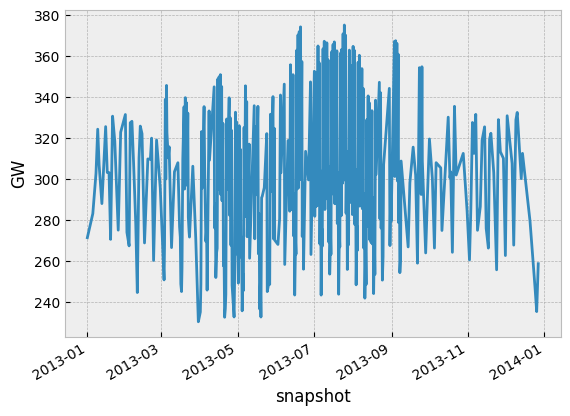

In [143]:
n.loads_t.p_set.loc[:, n.loads.query("carrier == 'electricity'").index].sum(axis=1).div(
    1e3
).plot(ylabel="GW")

## Explore Bidding Zones

To begin this section, let's start by examining the spatial resolution of the electricity grid representation 
in the Scenario Building Exercise which is the Bidding Zones.

Let's load the Bidding Zone shapes that we created for the PyPSA model:

In [144]:
bz = gpd.read_file("bidding_zones.geojson")

Let's have a look at the file:

In [145]:
bz.head()

zone_name country cross_country_zone  \
0      AL00      AL               None   
1      AT00      AT               None   
2      BA00      BA               None   
3      BE00      BE               None   
4      BG00      BG               None   

                                            geometry  
0  MULTIPOLYGON (((20.56881 41.87367, 20.50041 42...  
1  MULTIPOLYGON (((16.94357 48.60406, 16.87157 48...  
2  MULTIPOLYGON (((19.02249 44.85585, 18.84298 44...  
3  MULTIPOLYGON (((2.52183 51.08698, 2.59023 50.8...  
4  MULTIPOLYGON (((26.33246 41.71339, 26.54847 41...

Let's use a nice interactive plotting package to plot the regions.

`.hvplot()` is a powerful and interactive Pandas-like `.plot()` API. You just replace `.plot()` with `.hvplot()` and you get an interactive figure.

Documentation can be found here: https://hvplot.holoviz.org/index.html

In [146]:
def load_projection(plotting_params):
    proj_kwargs = plotting_params.get("projection", dict(name="EqualEarth"))
    proj_func = getattr(ccrs, proj_kwargs.pop("name"))
    return proj_func(**proj_kwargs)

In [147]:
# set the projection to specify for all geoplotting in this notebook
proj = load_projection(dict(name="EqualEarth"))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
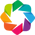

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (zone_name,country)

In [148]:
hv.extension("bokeh")
bz.hvplot(
    geo=True,
    tiles="OSM",
    hover_cols=["zone_name", "country"],
    c="zone_name",
    frame_height=700,
    frame_width=1000,
    alpha=0.2,
    legend=False,
).opts(xaxis=None, yaxis=None, active_tools=["pan", "wheel_zoom"])

## Explore the Electricity reference grid

The Electricity reference grid in the `PyPSA` model was implemented as HVAC lines that neglect KVL and only net transfer capacities (NTCs).

This is referred to as a `Transport Model`.

In `PyPSA`, this can be represented by the `link` component with carrier set to 'DC'.

Let's have a look at those links:

In [149]:
reference_grid_elec = n.links.query("carrier == 'DC'")
(
    reference_grid_elec.loc[
        :, ["p_nom", "p_nom_opt", "length", "p_nom_extendable"]
    ].head(10)
)

p_nom  p_nom_opt      length  p_nom_extendable
Link                                                         
AL00-GR00-DC   600.0        0.0  219.635111             False
AL00-ME00-DC   400.0        0.0  189.342890             False
AL00-MK00-DC   500.0        0.0  153.308707             False
AL00-RS00-DC   250.0        0.0  351.420535             False
AT00-CH00-DC  1200.0        0.0  502.028400             False
AT00-CZ00-DC   900.0        0.0  239.946178             False
AT00-DE00-DC  7500.0        0.0  512.754700             False
AT00-HU00-DC   800.0        0.0  324.765187             False
AT00-ITN1-DC   875.0        0.0  464.387903             False
AT00-SI00-DC   950.0        0.0  164.881961             False

Or we can compute the total transmission capacity of the system in `TWkm`:

In [150]:
total_TWkm = (
    reference_grid_elec.p_nom.div(1e6)  # convert from PyPSA's base unit MW to TW
    .mul(reference_grid_elec.length)
    .sum()
    .round(2)
)
print(
    f"Total electricity reference grid has a transmission capacity of {total_TWkm} TWkm."
)

Total electricity reference grid has a transmission capacity of 155.52 TWkm.


We can also check some individual number for specific connections using the `query()` or the `filter(like='<your-filter>')` method.

In [151]:
# example
# `query()`
print(reference_grid_elec.query("Link.str.contains('DE00-BE00')").p_nom)  # in MW
# or `filter()`
print(reference_grid_elec.filter(like="DE00-BE00", axis=0).p_nom)

Link
DE00-BE00-DC    1000.0
Name: p_nom, dtype: float64
Link
DE00-BE00-DC    1000.0
Name: p_nom, dtype: float64


In [152]:
# Task: extract and filter for specific capacity information from your home country and compare with your data about these connections

Additionally, we can also use `PyPSA`'s built in interactive `n.plot.explore()` function to explore the electricity reference grid:

In [153]:
# explore the reference grid
n_elec_grid = n.copy()
n_elec_grid.remove(
    "Bus", n_elec_grid.buses.query("carrier != 'AC' or Bus.str.contains('DRES')").index
)
n_elec_grid.explore()

/var/folders/mc/ydz19ftd49sd7q8qgcq53tkh0000gn/T/ipykernel_70260/3607125680.py:6: DeprecatedWarning:

explore is deprecated. Use `n.plot.explore()` as a drop-in replacement instead.

INFO:pypsa.plot.maps.interactive:Omitting 1842 links due to missing coordinates.
INFO:pypsa.plot.maps.interactive:Components rendered on the map: Bus, Link.
INFO:pypsa.plot.maps.interactive:Components omitted as they are missing or not selected: Generator, Line, Load, StorageUnit, Transformer.


We can also plot the electricity grid by utilizing a handy plotting function:

In [157]:
def plot_electricity_reference_grid(n, regions, proj):
    lw_factor = 1e3 if n.lines.empty else 2e3

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": proj})
    regions.to_crs(proj.proj4_init).plot(
        ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.75
    )
    n.plot.map(
        ax=ax,
        margin=0.06,
        line_widths=n.lines.s_nom / lw_factor,
        link_widths=n.links.p_nom / lw_factor,
    )

    if not n.lines.empty:
        sizes_ac = [10, 20]
        labels_ac = [f"HVAC ({s} GW)" for s in sizes_ac]
        scale_ac = 1e3 / lw_factor
        sizes_ac = [s * scale_ac for s in sizes_ac]

        legend_kw_ac = dict(
            loc=[0.25, 0.9],
            frameon=False,
            labelspacing=0.5,
            handletextpad=1,
            fontsize=13,
        )

        add_legend_lines(
            ax,
            sizes_ac,
            labels_ac,
            patch_kw=dict(color="rosybrown"),
            legend_kw=legend_kw_ac,
        )

    if not n.links.empty:
        sizes_dc = [1, 5]
        labels_dc = [f"HVDC ({s} GW)" for s in sizes_dc]
        scale_dc = 1e3 / lw_factor
        sizes_dc = [s * scale_dc for s in sizes_dc]

        legend_kw_dc = dict(
            loc=[0.0, 0.9],
            frameon=False,
            labelspacing=0.5,
            handletextpad=1,
            fontsize=13,
        )

        add_legend_lines(
            ax,
            sizes_dc,
            labels_dc,
            patch_kw=dict(color="darkseagreen"),
            legend_kw=legend_kw_dc,
        )

    plt.show()

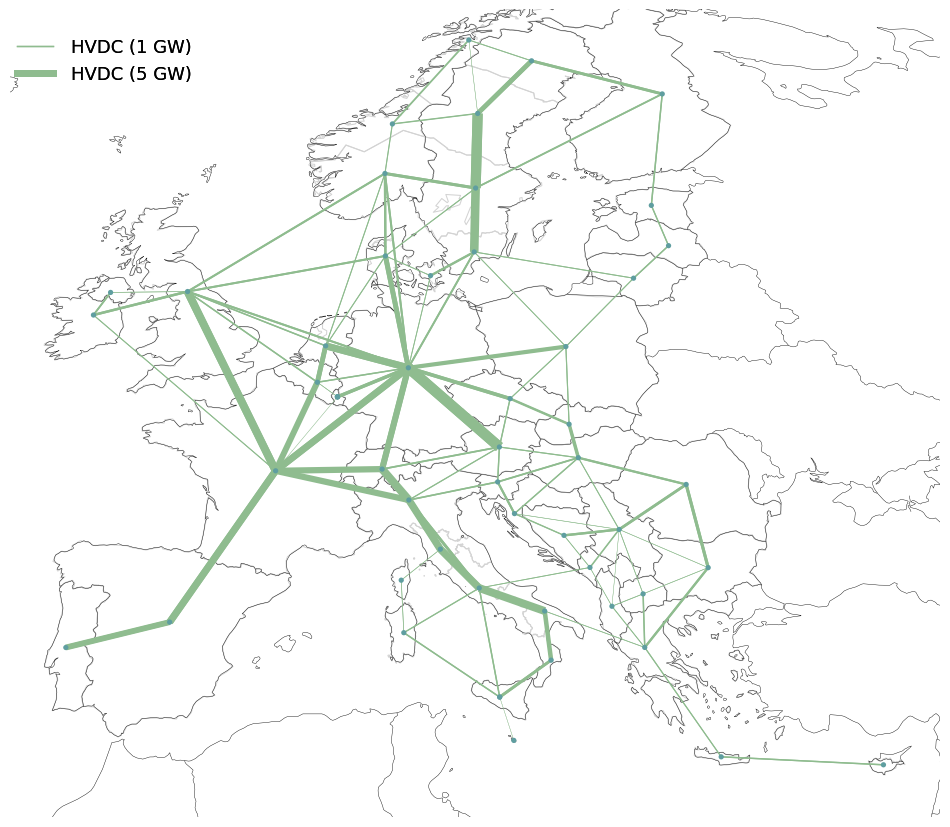

In [158]:
plot_electricity_reference_grid(n_elec_grid, bz, proj)

## Explore the Hydrogen reference grid

Similar to the Electricity reference grid, the H2 reference grid in the `PyPSA` model was implemented using the `link` component to represent the transport model of the Scenario Building exercise.

Let's have a look at those Hydrogen reference grid links:

In [159]:
reference_grid_h2 = n.links.query("carrier == 'H2 pipeline'")
(
    reference_grid_h2.loc[:, ["p_nom", "p_nom_opt", "length", "p_nom_extendable"]].head(
        10
    )
)

p_nom  p_nom_opt      length  p_nom_extendable
Link                                                                   
H2 pipeline AT -> DE    6250.0        0.0  768.287118             False
H2 pipeline AT -> IBIT  5250.0        0.0  694.620395             False
H2 pipeline AT -> SI       0.0        0.0  247.449222             False
H2 pipeline AT -> SK    6000.0        0.0  469.275999             False
H2 pipeline BE -> DE    3790.0        0.0  552.792303             False
H2 pipeline BE -> FR    4500.0        0.0  688.922156             False
H2 pipeline BE -> NL    2000.0        0.0  275.728663             False
H2 pipeline BG -> GR    3330.0        0.0  713.546718             False
H2 pipeline BG -> RO     740.0        0.0  574.542390             False
H2 pipeline CH -> IBIT  5630.0        0.0  267.045151             False

Again, we can compute the total transmission capacity of the system in `TWkm`:

In [160]:
total_TWkm = (
    reference_grid_h2.p_nom.div(1e6)  # convert from PyPSA's base unit MW to TW
    .mul(reference_grid_h2.length)
    .sum()
    .round(2)
)
print(f"The H2 reference grid has a total transmission capacity of {total_TWkm} TWkm.")

The H2 reference grid has a total transmission capacity of 334.77 TWkm.


And also extract and check some individual numbers for specific connections:

In [161]:
# Task: extract and filter for specific capacity information and compare with your data about these connections

Again, we can also use `PyPSA`'s built in interactive `n.plot.explore()` function to explore the hydrogen reference grid. 

As we can see, the spatial resolution of the H2 reference grid is different to the electricity reference grid.

In [162]:
# explore the reference grid
n_h2_grid = n.copy()
n_h2_grid.remove("Bus", n_h2_grid.buses.query("carrier != 'H2'").index)
n_h2_grid.remove("Link", n_h2_grid.links.query("p_nom == 0").index)
n_h2_grid.explore()

/var/folders/mc/ydz19ftd49sd7q8qgcq53tkh0000gn/T/ipykernel_70260/1962784955.py:5: DeprecatedWarning:

explore is deprecated. Use `n.plot.explore()` as a drop-in replacement instead.

INFO:pypsa.plot.maps.interactive:Omitting 208 links due to missing coordinates.
INFO:pypsa.plot.maps.interactive:Components rendered on the map: Bus, Link.
INFO:pypsa.plot.maps.interactive:Components omitted as they are missing or not selected: Generator, Line, Load, StorageUnit, Transformer.


We can also plot the electricity grid by importing and utilizing a handy plotting function:

In [166]:
def load_projection(plotting_params):
    proj_kwargs = plotting_params.get("projection", dict(name="EqualEarth"))
    proj_func = getattr(ccrs, proj_kwargs.pop("name"))
    return proj_func(**proj_kwargs)


def plot_h2_reference_grid(network, map_opts):
    n = network.copy()

    linewidth_factor = 4e3

    n.links.drop(
        n.links.index[~n.links.carrier.str.contains("H2 pipeline")], inplace=True
    )
    h2_pipes = n.links[n.links.carrier == "H2 pipeline"].p_nom
    link_widths_total = h2_pipes / linewidth_factor
    if link_widths_total.notnull().empty:
        print("No base H2 pipeline capacities to plot.")
        return
    link_widths_total = link_widths_total.reindex(n.links.index).fillna(0.0)

    proj = load_projection(dict(name="EqualEarth"))
    n.buses.drop(n.buses.index[~n.buses.carrier.str.contains("H2")], inplace=True)

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": proj})
    color_h2_pipe = "#499a9c"
    color_h2_node = "#ff29d9"

    n.plot.map(
        geomap=True,
        bus_sizes=0.1,
        bus_colors=color_h2_node,
        link_colors=color_h2_pipe,
        link_widths=link_widths_total,
        branch_components=["Link"],
        ax=ax,
        **map_opts,
    )

    sizes = [30, 10]
    labels = [f"{s} GW" for s in sizes]
    scale = 1e3 / 4e3
    sizes = [s * scale for s in sizes]

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0.01, 1.07),
        frameon=False,
        ncol=2,
        labelspacing=0.8,
        handletextpad=1,
    )

    add_legend_lines(
        ax,
        sizes,
        labels,
        patch_kw=dict(color="lightgrey"),
        legend_kw=legend_kw,
    )

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0.25, 1.13),
        labelspacing=0.8,
        handletextpad=0,
        frameon=False,
    )

    add_legend_circles(
        ax,
        sizes=[0.2],
        labels=["H2 Node"],
        srid=n.srid,
        patch_kw=dict(facecolor=color_h2_node),
        legend_kw=legend_kw,
    )

    colors = [color_h2_pipe]
    labels = ["H2 Pipeline"]

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0, 1.13),
        ncol=1,
        frameon=False,
    )

    add_legend_patches(ax, colors, labels, legend_kw=legend_kw)

    ax.set_facecolor("white")

    plt.show()

In [169]:
proj = load_projection(dict(name="EqualEarth"))
map_opts = {
    "boundaries": [-11, 30, 34, 71],
    "geomap_colors": {
        "ocean": "white",
        "land": "white",
    },
}

/Users/daniel/mambaforge/envs/open-tyndp-workshops/lib/python3.12/site-packages/pypsa/plot/maps/static.py:1678: UserWarning:

When combining n.plot() with other plots on a geographical axis, ensure n.plot() is called first or the final axis extent is set initially (ax.set_extent(boundaries, crs=crs)) for consistent legend circle sizes.



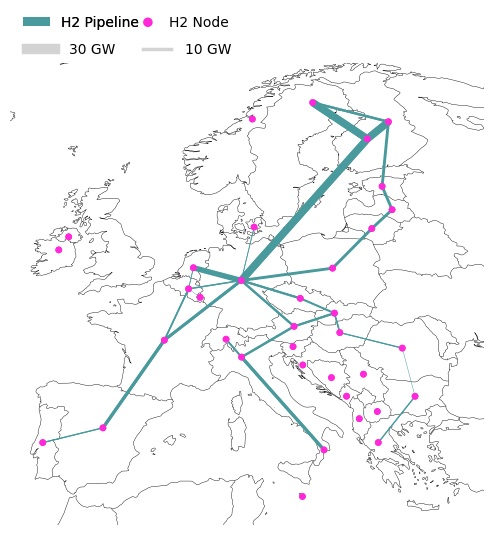

In [170]:
plot_h2_reference_grid(n_h2_grid, map_opts)

# Hands-on Session 2: Extracting insights & Visualization

## Import the solved model

In [171]:
n = pypsa.Network("post-network.nc")

INFO:pypsa.io:Imported network post-network.nc has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores


## Extract insights from the network: The `PyPSA.statistics` module

Let's investigate the results from the solved model.

First, we would like to see the optimal power plant capacities in the model:

In [172]:
n.statistics().T

Generator                     \
                        Offshore Wind (AC) Offshore Wind (DC)   
Optimal Capacity              4.222215e+04       5.067490e+04   
Installed Capacity            6.580284e+03       1.335065e+04   
Supply                        1.765378e+08       2.500630e+08   
Withdrawal                    0.000000e+00       0.000000e+00   
Energy Balance                1.765378e+08       2.500630e+08   
Transmission                  0.000000e+00       0.000000e+00   
Capacity Factor               4.773020e-01       5.633163e-01   
Curtailment                   1.502211e+06       1.095987e+06   
Capital Expenditure           8.531506e+09       1.165300e+10   
Operational Expenditure       4.466614e+06       6.209362e+06   
Revenue                       8.606860e+09       1.197855e+10   
Market Value                  4.875364e+01       4.790215e+01   

                                                                              \
                        Offshore Wind (Floating)  Onshore Wind  Run of River   
Optimal Capacity                    5.074368e+03  3.267886e+05  4.777413e+04   
Installed Capacity                  5.074356e+03  1.848457e+05  4.777413e+04   
Supply                              2.122442e+07  8.147271e+08  1.698666e+08   
Withdrawal                          0.000000e+00  0.000000e+00  0.000000e+00   
Energy Balance                      2.122442e+07  8.147271e+08  1.698666e+08   
Transmission                        0.000000e+00  0.000000e+00  0.000000e+00   
Capacity Factor                     4.774741e-01  2.846041e-01  4.058926e-01   
Curtailment                         5.647373e+05  1.656320e+07  6.082543e+05   
Capital Expenditure                 1.251261e+09  3.781592e+10  1.472257e+10   
Operational Expenditure             5.418262e+05  2.050222e+07  1.727120e+06   
Revenue                             9.005340e+08  3.295203e+10  8.341871e+09   
Market Value                        4.242914e+01  4.044548e+01  4.910837e+01   

                                                                         \
                                Solar      coal           gas   lignite   
Optimal Capacity         1.529582e+05   0.00000  1.047203e+06   0.00000   
Installed Capacity       1.529582e+05   0.00000  0.000000e+00   0.00000   
Supply                   1.647359e+08   0.00015  3.307211e+09   0.00014   
Withdrawal               0.000000e+00   0.00000  0.000000e+00   0.00000   
Energy Balance           1.647359e+08   0.00015  3.307211e+09   0.00014   
Transmission             0.000000e+00   0.00000  0.000000e+00   0.00000   
Capacity Factor          1.229452e-01   0.00000  3.605181e-01   0.00000   
Curtailment              2.845343e+06   0.00045  5.866285e+09   0.00044   
Capital Expenditure      8.008749e+09   0.00000  0.000000e+00   0.00000   
Operational Expenditure  3.292821e+06   0.00140  8.128478e+10   0.00047   
Revenue                  6.439342e+09 -17.96688  8.128478e+10 -17.92695   
Market Value             3.908887e+01       NaN  2.457805e+01       NaN   

                                     ...      Store                          \
                        oil primary  ... co2 stored        coal         gas   
Optimal Capacity            0.00000  ...   0.320390  413.480940   22.118810   
Installed Capacity          0.00000  ...   0.000000    0.000000    0.000000   
Supply                      0.00117  ...   3.771120    0.000000  182.133820   
Withdrawal                  0.00000  ...   3.771120    0.000150  182.133820   
Energy Balance              0.00117  ...   0.000000   -0.000150    0.000000   
Transmission                0.00000  ...   0.000000    0.000000    0.000000   
Capacity Factor             0.00000  ...   0.518868    0.216243    0.482026   
Curtailment                 0.00356  ...   0.000000    0.000000    0.000000   
Capital Expenditure         0.00000  ...  79.330410   41.348090   81.591680   
Operational Expenditure     0.06182  ...   0.000000    0.000000    0.000000   
Re

In [173]:
(
    n.statistics.optimal_capacity(
        bus_carrier=["AC", "low voltage"],
        groupby=["location", "carrier"],
    )
    .div(1e3)  # GW
    .sort_values(ascending=False)
    .to_frame(name="p_nom_opt")
    .query("p_nom_opt>1e-3")
    .pivot_table(index="location", columns="carrier", values="p_nom_opt")
    .fillna(0)
    .sort_values(by=["Onshore Wind"], ascending=False)
)

carrier      DC  Offshore Wind (AC)  Offshore Wind (DC)  \
location                                                  
GB00      0.000            3.269502            3.281437   
DE00      0.900            4.244243           21.696670   
NL00      0.000            0.151433            2.303442   
ES00      0.000            0.000000            0.000000   
DKW1      0.010            0.277933            0.277933   
FR00      0.000           27.600923            6.905726   
BE00      1.000            1.053971            1.193031   
DKE1      0.000            0.289000            0.289000   
PL00      0.000            5.165245            5.810275   
GBNI      0.100            0.031387            0.008654   
PT00      0.700            0.005614            0.000000   
SE02      0.000            0.000000            5.696444   
EE00      0.000            0.000000            0.000000   
IE00      0.000            0.001816            1.022690   
GR00      0.050            0.000000            0.000000   
SE03      0.000            0.040000            0.040000   
AT00      0.000            0.000000            0.000000   
SE04      3.800            0.053717            1.569963   
RO00      0.000            0.000000            0.000000   
FI00      0.000            0.036414            0.577306   
ITCN      1.500            0.000000            0.000000   
SE01      0.100            0.000000            0.000000   
ITS1      0.000            0.000000            0.000000   
GR03      0.000            0.000000            0.000000   
ITSA      0.000            0.000000            0.000000   
NON1      0.000            0.000000            0.000000   
ITSI      0.000            0.000000            0.000000   
ITN1      4.440            0.000000            0.000000   
ITCS      2.080            0.000000            0.000000   
NOS0      0.150            0.000000            0.000000   
NOM1      1.150            0.000000            0.000000   
HR00      0.400            0.000000            0.000000   
BG00      0.000            0.000000            0.000000   
ITCA      0.000            0.000000            0.000000   
LT00      0.000            0.000000            0.002313   
RS00      0.000            0.000000            0.000000   
CZ00      0.000            0.000000            0.000000   
HU00      0.431            0.000000            0.000000   
CY00      0.000            0.000000            0.000000   
LUB1      0.380            0.000000            0.000000   
ME00      0.600            0.000000            0.000000   
CH00      0.000            0.000000            0.000000   
BA00      0.000            0.000000            0.000000   
MT00      0.000            0.000000            0.000000   
LV00      0.071            0.000000            0.000000   
ITCO      0.060            0.000000            0.000000   
MK00      0.270            0.000000            0.000000   
SK00      0.000            0.000000            0.000000   
SI00      0.000            0.000000            0.000000   
LUG1      0.120            0.000000            0.000000   
LUF1      0.380            0.000000            0.000000   
AL00      0.000            0.000000            0.000000   

carrier   Offshore Wind (Floating)  Onshore Wind  Open-Cycle Gas  \
location                                                           
GB00                      3.570697     79.104447        8.101277   
DE00                      0.531021     54.414000       12.606290   
NL00                      0.004626     38.734315        5.178931   
ES00                      0.004081     26.814190        0.000000   
DKW1                      0.277933     20.043041        0.021611   
FR00                      0.001474     17.483259        0.041062   
BE00                      0.014798      8.740996        6.969843   
DKE1                      0.289000      8.598056        0.000000   
PL00                      0.000000      6.298250        3.753849   
GBNI                      0.221223      6.084058        0.682923 

We can also easily look into the energy balance for a specific carrier by Node. 

So, let's investigate the Hydrogen balance at the Z1 and Z2 nodes of Germany (DE):

In [177]:
(
    n.statistics.energy_balance(carrier="H2", groupby=["bus", "country", "carrier"])
    .div(1e3)
    .to_frame(name="balance_GW")
    .query("bus.str.contains('DE H2')")
)

balance_GW
component bus      country carrier                    
Link      DE H2 Z1 DE      H2 Electrolysis    0.000322
                           H2 pipeline       -0.010344
          DE H2 Z2 DE      H2 Electrolysis    0.000444
                           H2 pipeline        0.003000
                           H2 turbine        -0.001472

... or look at renewable curtailment in the system:

In [178]:
(
    n.statistics.curtailment(
        bus_carrier=["AC", "low voltage"],
        groupby=["location", "carrier"],
    )
    .div(1e3)  # GW
    .sort_values(ascending=False)
    .to_frame(name="p_nom_opt")
    .query("p_nom_opt>1e-3")
    .pivot_table(index="location", columns="carrier", values="p_nom_opt")
    .fillna(0)
    .sort_values(by=["Onshore Wind"], ascending=False)
)

carrier   Offshore Wind (AC)  Offshore Wind (DC)  Offshore Wind (Floating)  \
location                                                                     
GB00                2.993021            3.766603                171.525774   
ES00                0.151207            0.000000                  0.576317   
DKW1                5.163559          127.923218                  4.276120   
GBNI               15.846761            4.048184                124.940439   
NL00               53.840369          718.309559                  1.426776   
DKE1              224.691371           11.190040                257.930561   
GR03                0.000000            0.000000                  0.000000   
GR00                0.000000            0.000000                  0.000000   
FR00             1185.078191          194.597104                  0.139522   
ITSI                0.000000            0.000000                  0.000000   
ITS1                0.000000            0.000000                  0.000000   
ITSA                0.000000            0.000000                  0.000000   
IE00                0.351774            0.986452                  1.425663   
CY00                0.000000            0.000000                  0.000000   
MT00                0.000000            0.000000                  0.000000   
EE00                0.000000            0.000000                  0.000000   
ITCA                0.000000            0.000000                  0.000000   
ITCO                0.000000            0.000000                  0.000000   
ITCN                0.000000            0.000000                  0.000000   
RO00                0.001226            0.000000                  0.000000   
PT00                0.743858            0.000000                  1.822466   
BG00                0.000000            0.000000                  0.000000   
BE00               12.864843            0.445843                  0.194656   
ITCS                0.000000            0.000000                  0.000000   
SE02                0.000000           34.191506                  0.000000   
MK00                0.000000            0.000000                  0.000000   
DE00                0.130473            0.196112                  0.129309   
HR00                0.000000            0.000000                  0.000000   
ITN1                0.000000            0.000000                  0.000000   
RS00                0.000000            0.000000                  0.000000   
SE03                0.170484            0.142375                  0.155627   
HU00                0.000000            0.000000                  0.000000   
LV00                0.000000            0.000000                  0.000000   
CH00                0.000000            0.000000                  0.000000   
ME00                0.000000            0.000000                  0.000000   
AT00                0.000000            0.000000                  0.000000   
NOS0                0.000000            0.000000                  0.024055   
BA00                0.000000            0.000000                  0.000000   
SE04                0.091458            0.070183                  0.097036   
SE01                0.000000            0.000000                  0.000000   
LT00                0.000000            0.028819                  0.000000   
CZ00                0.000000            0.000000                  0.000000   
PL00                0.038627            0.045862                  0.000000   
FI00                0.046550            0.038174                  0.055800   
NON1                0.000000            0.000000                  0.005478   
NOM1                0.000000            0.000000                  0.005456   
SK00                0.000000            0.000000                  0.000000   
SI00                0.000000            0.000000                  0.000000   
LUB1                0.000000            0.000000                  0.000000   
AL00                0.

## Visualizing results with the `PyPSA.statistics` module

The `PyPSA.statistics` module can also be used to create some really handy static plotting to investigate the results of a model:

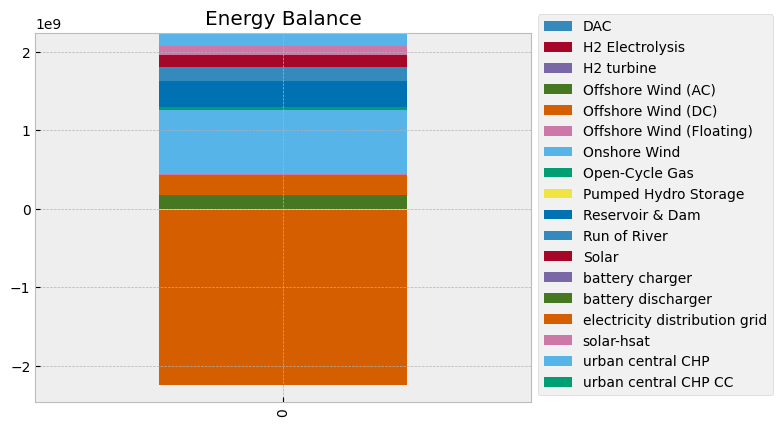

In [179]:
fig, ax = plt.subplots()
n.statistics.energy_balance().loc[:, :, "AC"].groupby(
    "carrier"
).sum().to_frame().T.plot.bar(stacked=True, ax=ax, title="Energy Balance")
ax.legend(bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)

In [180]:
# insert Fabian's cool statistics.plot examples here

Example: With some tweaking and construction, we can use PyPSA's plotting to create some really cool visualizations of the resulting net hydrogen flows in the network:

In [192]:
def plot_net_H2_flows(n, regions, countries=[], figsize=(8, 8)):
    network = n.copy()
    # if "H2 pipeline" not in n.links.carrier.unique():
    #     return
    if len(countries) == 0:
        countries = regions.index.values

    linewidth_factor = 5e2
    # MW below which not drawn
    line_lower_threshold = 1e2
    min_energy = 0
    lim = 50
    link_color = "#499a9c"
    flow_factor = 100

    # get H2 energy balance per node
    carrier = "H2"
    h2_energy_balance = network.statistics.energy_balance(bus_carrier = "H2", comps="Link", groupby=["country", "carrier"]).to_frame()

    to_drop = ["H2 pipeline"]
    # drop pipelines and storages from energy balance
    h2_energy_balance.drop(h2_energy_balance.loc[:,to_drop,:].index, inplace=True)
    # filter for countries
    # h2_energy_balance = h2_energy_balance.loc[countries,:,:]
    # regions = regions.loc[countries]

    regions["H2"] = (
        h2_energy_balance
        .groupby(level=0)
        .sum()
        # .div(1e6)  # TWh
        .mul(-1)  # so demand is positive and supply is negative
    )

    # Drop non-hydrogen buses so they don't clutter the plot
    # And filter for countries
    network.buses.drop(network.buses.query("carrier != 'H2'").index, inplace=True)
    # network.buses.drop(network.buses.query("country not in @countries").index, inplace=True)

    # drop all links which are not H2 pipelines
    network.links.drop(
        network.links.index[~network.links.carrier.str.contains("H2 pipeline")], inplace=True
    )

    network.links["flow"] = network.snapshot_weightings.generators @ network.links_t.p0

    positive_order = network.links.bus0 < network.links.bus1
    swap_buses = {"bus0": "bus1", "bus1": "bus0"}
    network.links.loc[~positive_order] = network.links.rename(columns=swap_buses)
    network.links.loc[~positive_order, "flow"] = -network.links.loc[~positive_order, "flow"]
    network.links.index = network.links.apply(lambda x: f"H2 pipeline {x.bus0} -> {x.bus1}", axis=1)
    network.links = network.links.groupby(network.links.index).agg(
        dict(flow="sum", bus0="first", bus1="first", carrier="first", p_nom_opt="sum")
    )
    network.links.flow = network.links.flow.where(network.links.flow.abs() > min_energy)

    # drop links not connecting countries in country list
    # network.links.drop(network.links.loc[((~network.links.bus0.str.contains('|'.join(countries))) | (~network.links.bus1.str.contains('|'.join(countries))))].index, inplace=True)
    # n.links.loc[((n.links.bus0.str.contains('|'.join(countries))) & (n.links.bus1.str.contains('|'.join(countries))))]

    proj = ccrs.EqualEarth()
    regions = regions.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": proj})

    link_widths_flows = network.links.flow.div(linewidth_factor).fillna(0)
    # cap link width
    link_widths_flows = (
        link_widths_flows
        .where((link_widths_flows.abs() < 1) | (link_widths_flows < 0), 1)  # 1 where not between 0 and 1 or negative
        .where((link_widths_flows.abs() < 1) | (link_widths_flows > 0), -1)  # -1 where not between 0 and -1 or positive
    )

    network.plot.map(
        geomap=True,
        bus_sizes=0,
        link_colors=link_color,
        link_widths=link_widths_flows,
        branch_components=["Link"],
        ax=ax,
        flow=pd.concat({"Link": link_widths_flows*flow_factor}),
        **map_opts,
    )

    regions.plot(
        ax=ax,
        column="H2",
        cmap="BrBG",
        linewidths=0,
        legend=True,
        vmax=lim,
        vmin=-lim,
        legend_kwds={
            "label": "Hydrogen balance [MWh] \n + Supply, - Demand",
            "shrink": 0.7,
            "extend": "max",
        },
    )

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(-0.1, 1.13),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1,
    )

    sizes = [2, 1, 0.5]
    sizes_str = {2: " over", 1: "", 0.5: ""}
    labels = [f"Hydrogen flows{sizes_str[s]} {s} GWh" for s in sizes]
    scale = 1e3 / linewidth_factor
    sizes = [s * scale for s in sizes]
    add_legend_lines(
        ax,
        sizes,
        labels,
        patch_kw=dict(color=link_color),
        legend_kw=legend_kw,
    )

    ax.set_facecolor("white")

ValueError: too many values to unpack (expected 4)

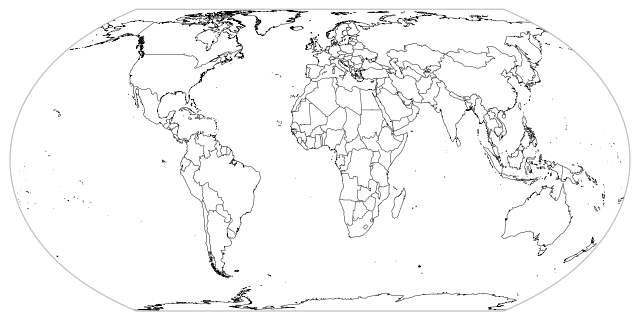

In [193]:
h2_regions = bz.dissolve(by="country")
plot_net_H2_flows(n, h2_regions)